In [2]:
# ==============================
# Generate SELFIES from ChemQ3MTP checkpoint
# LOADING THE MODEL & TOKENIZER
# ================================

import sys
import os
import torch

# --- Replicate local module loading exactly as in training ---
notebook_dir = os.getcwd()
chemq3mtp_path = os.path.join(notebook_dir, "ChemQ3MTP")

if chemq3mtp_path not in sys.path:
    sys.path.insert(0, chemq3mtp_path)

# Optional: clean up duplicate paths (as in your training script)
existing_paths = [p for p in sys.path if p.endswith("ChemQ3MTP")]
for path in existing_paths[:-1]:  # keep only the most recently added
    sys.path.remove(path)

# Now import from local ChemQ3MTP folder
from FastChemTokenizerHF import FastChemTokenizerSelfies
from ChemQ3MTP import ChemQ3MTPForCausalLM  # <-- your custom model

# --- Load from checkpoint (same as saved in training) ---
checkpoint_dir = "./ChemQ"  # or your actual checkpoint path

print(f"Loading tokenizer from {checkpoint_dir}...")
tokenizer = FastChemTokenizerSelfies.from_pretrained('./selftok_core/')

print(f"Loading ChemQ3MTP model from {checkpoint_dir}...")
model = ChemQ3MTPForCausalLM.from_pretrained(checkpoint_dir)

# --- Prepare for generation ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Disable MTP mode for standard autoregressive generation
if hasattr(model, 'set_mtp_training'):
    model.set_mtp_training(False)

try:
    # Tokenize start token
    input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
    
    with torch.no_grad():
        gen = model.generate(
            input_ids=input_ids,
            max_length=256,
            top_k=50,
            temperature=1.0,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            early_stopping=True
        )
    
    result = tokenizer.decode(gen[0], skip_special_tokens=True)
    print("Generated SELFIES:")
    print(result)

except Exception as e:
    print(f"Generation failed: {e}")
    import traceback
    traceback.print_exc()

Loading tokenizer from ./ChemQ...
✅ Special tokens bound: 0 1 2 3 4
Loading ChemQ3MTP model from ./ChemQ...


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated SELFIES:
[C] [=C] [C] [=C] [NH1] [C] [Branch2] [Ring2] [#Branch1] [C] [=C] [C] [=C] [Branch2] [Ring1] [O] [C] [=N] [N] [=C] [N] [Ring1] [Branch1] [C] [=C] [C] [=C] [N] [=C] [Ring1] [=Branch1] [N] [C] [=C] [C] [=C] [C] [=C] [Ring1] [=Branch1] [Ring1] [#C] [C] [=C] [Ring2] [Ring1] [Branch2] [=N] [C] [Ring2] [Ring1] [=N] [=C] [Ring2] [Ring1] [P]


🚀 Starting molecular generation pipeline...

1. Generating 1000 molecules in batches of 5...


Generating batches:   0%|          | 0/200 [00:00<?, ?batch/s]

✅ Generated 1000 sequences total

2. Decoding SELFIES → SMILES and validating...


Decoding & validating:   0%|          | 0/1000 [00:00<?, ?mol/s]

✅ Valid SMILES: 976 (97.60%)

3. Evaluating Lipinski's Rule of 5...


Lipinski evaluation:   0%|          | 0/976 [00:00<?, ?mol/s]

✅ Lipinski-compliant: 687 (70.39% of valid)

4. Computing molecular fingerprints...


Computing MACCS fingerprints:   0%|          | 0/976 [00:00<?, ?mol/s]


5. Calculating internal diversity...


Computing diversity:   0%|          | 0/475800 [00:00<?, ?pair/s]

✅ Internal diversity: 0.6387

6. Performing molecular clustering...


Computing distance matrix:   0%|          | 0/475800 [00:00<?, ?pair/s]

Performing Butina clustering...
✅ Number of clusters: 448
✅ Average cluster size: 2.18
✅ Largest cluster: 15 molecules

7. Creating visualizations...
Preparing fingerprint array...


Converting fingerprints:   0%|          | 0/976 [00:00<?, ?fp/s]

Computing PCA...
Computing t-SNE...


d:\ProgramData\miniconda3\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


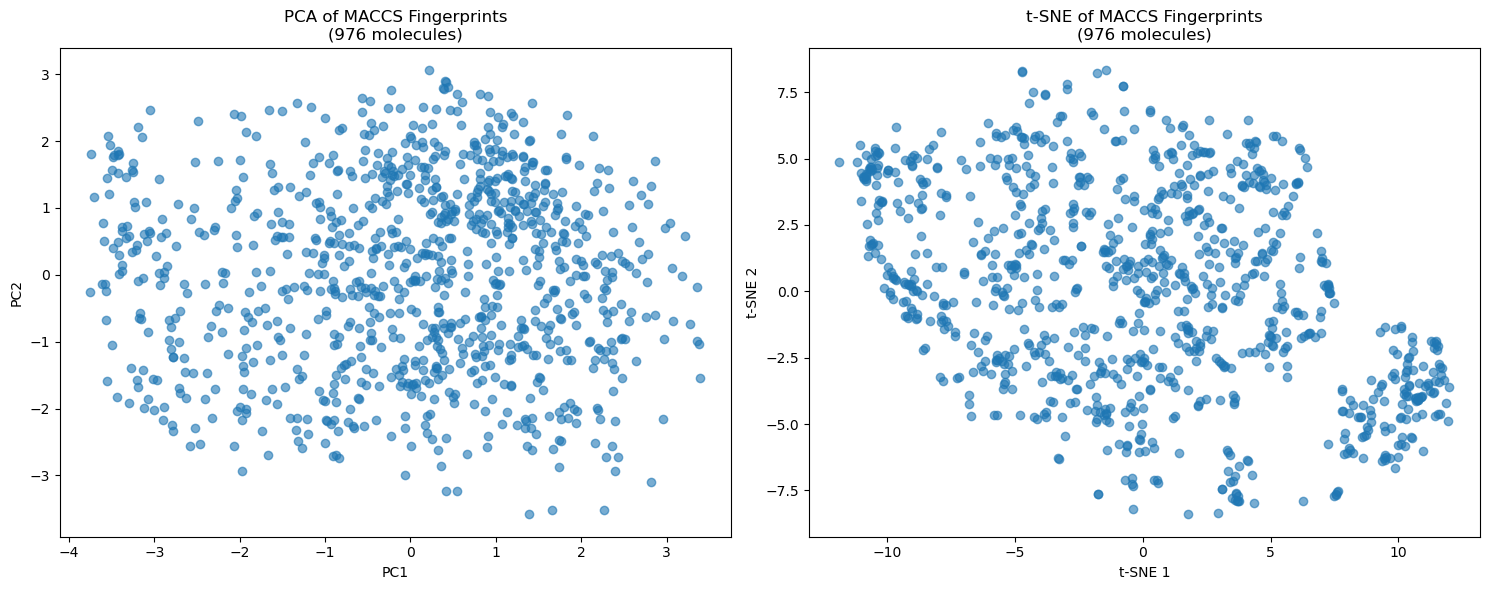


📊 FINAL EVALUATION SUMMARY
Total generated:          1000
Valid SMILES:             976 (97.6%)
Lipinski-compliant:       687 (70.4% of valid)
Internal diversity:       0.6387
MACCS clusters (≥0.7):    448
Average cluster size:     2.18
Largest cluster size:     15

✅ Results dictionary created
✅ Valid SMILES saved to 'generated_valid_2500.smi'
✅ Cluster visualization saved as 'molecular_clusters.png'


In [3]:
# ================================
# MOLECULAR GENERATION & EVALUATION PIPELINE
# ================================

# Core imports
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Cluster import Butina
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import selfies as sf
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')

# ================================
# 1. GENERATE 2.5K MOLECULES IN BATCHES
# ================================
print("🚀 Starting molecular generation pipeline...\n")

num_samples = 1000
batch_size = 5
num_batches = (num_samples + batch_size - 1) // batch_size

print(f"1. Generating {num_samples} molecules in batches of {batch_size}...")

gen = []
for batch_idx in tqdm(range(num_batches), desc="Generating batches", unit="batch"):
    # Calculate how many to generate in this batch
    remaining = num_samples - len(gen)
    current_batch_size = min(batch_size, remaining)
    
    batch_gen = model.generate(
        max_length=512,
        num_return_sequences=current_batch_size,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    gen.extend(batch_gen)

print(f"✅ Generated {len(gen)} sequences total")

# ================================
# 2. DECODE TO SMILES & VALIDATE
# ================================
print("\n2. Decoding SELFIES → SMILES and validating...")
valid_smiles = []

for i in tqdm(range(num_samples), desc="Decoding & validating", unit="mol"):
    try:
        selfies_str = tokenizer.decode(gen[i], skip_special_tokens=True)
        selfies_str = selfies_str.replace(' ', '')
        smiles = sf.decoder(selfies_str)
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None and smiles.strip() != '' and '.' not in smiles:
            valid_smiles.append(smiles)
    except:
        continue

print(f"✅ Valid SMILES: {len(valid_smiles)} ({100 * len(valid_smiles)/num_samples:.2f}%)")

# ================================
# 3. LIPINSKI EVALUATION
# ================================
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    violations = 0
    if mw > 500: violations += 1
    if logp > 5: violations += 1
    if hbd > 5: violations += 1
    if hba > 10: violations += 1
    return violations == 0

print("\n3. Evaluating Lipinski's Rule of 5...")
lipinski_pass = 0
for smiles in tqdm(valid_smiles, desc="Lipinski evaluation", unit="mol"):
    mol = Chem.MolFromSmiles(smiles)
    if passes_lipinski(mol):
        lipinski_pass += 1

print(f"✅ Lipinski-compliant: {lipinski_pass} ({100 * lipinski_pass/len(valid_smiles):.2f}% of valid)")

# ================================
# 4. MACCS FINGERPRINTS
# ================================
def calculate_maccs_fingerprints(smiles_list):
    """Calculate MACCS fingerprints for a list of SMILES"""
    fingerprints = []
    mols = []
    
    for smiles in tqdm(smiles_list, desc="Computing MACCS fingerprints", unit="mol"):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = MACCSkeys.GenMACCSKeys(mol)
            fingerprints.append(fp)
            mols.append(mol)
    
    return fingerprints, mols

print("\n4. Computing molecular fingerprints...")
generated_fingerprints, generated_mols = calculate_maccs_fingerprints(valid_smiles)

# ================================
# 5. INTERNAL DIVERSITY
# ================================
def calculate_internal_diversity(fingerprints, sample_size=1000):
    """Calculate internal diversity of generated molecules"""
    if len(fingerprints) < 2:
        return 0.0
    
    if len(fingerprints) > sample_size:
        random.seed(42)
        sampled_fps = random.sample(fingerprints, sample_size)
    else:
        sampled_fps = fingerprints
    
    distances = []
    n = len(sampled_fps)
    total_pairs = n * (n - 1) // 2
    
    with tqdm(total=total_pairs, desc="Computing diversity", unit="pair") as pbar:
        for i in range(n):
            for j in range(i+1, n):
                dist = 1 - DataStructs.TanimotoSimilarity(sampled_fps[i], sampled_fps[j])
                distances.append(dist)
                pbar.update(1)
    
    return np.mean(distances) if distances else 0.0

print("\n5. Calculating internal diversity...")
internal_div = calculate_internal_diversity(generated_fingerprints, sample_size=1000)
print(f"✅ Internal diversity: {internal_div:.4f}")

# ================================
# 6. CLUSTERING
# ================================
def cluster_molecules(fingerprints, cutoff=0.7):
    """Cluster molecules using Butina clustering"""
    sample_size = min(2000, len(fingerprints))
    if len(fingerprints) > sample_size:
        random.seed(42)
        sampled_fps = random.sample(fingerprints, sample_size)
    else:
        sampled_fps = fingerprints
    
    dists = []
    n = len(sampled_fps)
    total_pairs = n * (n - 1) // 2
    
    with tqdm(total=total_pairs, desc="Computing distance matrix", unit="pair") as pbar:
        for i in range(n):
            for j in range(i+1, n):
                dist = 1 - DataStructs.TanimotoSimilarity(sampled_fps[i], sampled_fps[j])
                dists.append(dist)
                pbar.update(1)
    
    print("Performing Butina clustering...")
    cluster_indices = Butina.ClusterData(dists, n, 1 - cutoff, isDistData=True)
    
    return cluster_indices

print("\n6. Performing molecular clustering...")
cluster_indices = cluster_molecules(generated_fingerprints, cutoff=0.7)
n_clusters = len(cluster_indices)
cluster_sizes = [len(cluster) for cluster in cluster_indices]
largest_cluster = max(cluster_sizes) if cluster_sizes else 0

print(f"✅ Number of clusters: {n_clusters}")
print(f"✅ Average cluster size: {np.mean(cluster_sizes):.2f}")
print(f"✅ Largest cluster: {largest_cluster} molecules")

# ================================
# 7. VISUALIZATION
# ================================
def visualize_clusters(fingerprints, smiles_list):
    """Visualize clusters using PCA and t-SNE"""
    print("Preparing fingerprint array...")
    fp_array = []
    for fp in tqdm(fingerprints, desc="Converting fingerprints", unit="fp", leave=False):
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, arr)
        fp_array.append(arr)
    
    fp_array = np.array(fp_array)
    
    if len(fp_array) > 1000:
        random.seed(42)
        indices = random.sample(range(len(fp_array)), 1000)
        fp_array = fp_array[indices]
        sampled_smiles = [smiles_list[i] for i in indices]
    else:
        sampled_smiles = smiles_list
    
    print("Computing PCA...")
    pca = PCA(n_components=2)
    pca_coords = pca.fit_transform(fp_array)
    
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, 
                perplexity=min(30, len(fp_array)-1), max_iter=300)
    tsne_coords = tsne.fit_transform(fp_array)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.6)
    axes[0].set_title(f'PCA of MACCS Fingerprints\n({len(fp_array)} molecules)')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    
    axes[1].scatter(tsne_coords[:, 0], tsne_coords[:, 1], alpha=0.6)
    axes[1].set_title(f't-SNE of MACCS Fingerprints\n({len(fp_array)} molecules)')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    
    plt.tight_layout()
    plt.savefig('molecular_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n7. Creating visualizations...")
if len(generated_fingerprints) > 10:
    visualize_clusters(generated_fingerprints, valid_smiles)

# ================================
# 8. FINAL SUMMARY
# ================================
print("\n" + "="*60)
print("📊 FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Total generated:          {num_samples}")
print(f"Valid SMILES:             {len(valid_smiles)} ({100 * len(valid_smiles)/num_samples:.1f}%)")
print(f"Lipinski-compliant:       {lipinski_pass} ({100 * lipinski_pass/len(valid_smiles):.1f}% of valid)")
print(f"Internal diversity:       {internal_div:.4f}")
print(f"MACCS clusters (≥0.7):    {n_clusters}")
print(f"Average cluster size:     {np.mean(cluster_sizes):.2f}")
print(f"Largest cluster size:     {largest_cluster}")
print("="*60)

results = {
    'total_generated': num_samples,
    'valid_smiles': len(valid_smiles),
    'validity_rate': len(valid_smiles)/num_samples,
    'lipinski_compliant': lipinski_pass,
    'lipinski_rate_valid': lipinski_pass/len(valid_smiles) if valid_smiles else 0,
    'internal_diversity': internal_div,
    'num_clusters': n_clusters,
    'avg_cluster_size': np.mean(cluster_sizes) if cluster_sizes else 0,
    'largest_cluster_size': largest_cluster
}

with open("generated_valid_2500.smi", "w") as f:
    for smi in valid_smiles:
        f.write(smi + "\n")

print(f"\n✅ Results dictionary created")
print(f"✅ Valid SMILES saved to 'generated_valid_2500.smi'")
print(f"✅ Cluster visualization saved as 'molecular_clusters.png'")